<a href="https://colab.research.google.com/github/AxinLi1/CS436HW3/blob/main/LinearModelsTODO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS 436 / 536: Introduction to Machine Learning
## Linear Models with the MNIST Digits Dataset. Among Other Things ...

In [69]:
'''
Init

This is a HACK!

Check the execute flag
'''

execute = True

# Warning:
### <p style="color:red;"> All arrays / matrices in the text explanations are 1-indexed</p>
### <p style="color:red;"> All Python / NumPy arrays are 0-indexed</p>

This code is for reference only. You are free to use any parts of this code you find useful. This code is not optimized. There are possibly many better ways to write this. Please contact me if you find any bugs or have any improvements to any parts of this code. For sufficiently signficant contributions, I am happy to provide extra credit for your work. Happy learning! :)

# Table of Contents

## [Dependencies on Other Python Libraries](#dependencies)

## Task 1: [Working with Data](#data)

### 1.1 [Reading the MNIST / USPS Digits Dataset](#reading)

- 1.1.1 [Read the Input Data Set](#readinput)
- 1.1.2 [Read the Test Data Set](#readtest)
- 1.1.3 [Display a Handwritten Digit](#displayimg)

## Task 2: [Set up the Learning Problem. Compute the "Augmented" Feature Matrix: $\mathcal{X}$-space](#learningproblem)

### 2.1 [Computing Features: Intensity and Symmetry](#features)

### 2.2 [Compute the "Augmented Feature Matrix"](#augmented)

### 2.3 [Set up the 1s vs. 5s Classification Problem](#1v5)

### 2.4 [Visualizing Data: Plot Data Points in 2 dimensions](#scatter)

## Task 3: [The Linear Model (in $\mathcal{X}$-space)](#linear)

### 3.1 [Plotting a Linear Separator](#plotlin)

### 3.2 [The Point-wise Error Function for Classification](#error)

### 3.3 [The Pocket Algorithm (and the Perceptron Learning Algorithm)](#pocket)

### 3.4 [Linear Regression: The One Step $E_\text{in}$ Minimizing Algorithm](#linreg)

- 3.4.1 [Linear Regression for Classification](#linreg4class)

### 3.5 [Logistic Regression](#logreg)

- 3.5.1 [An Example of Gradient Descent: Minimizing a function's value](#gradmin)

- 3.5.2 [Logistic Regression: Cross Entropy Error and Gradient Descent](#logreggrad)

## Task 4: [The Polynomial Transform: $\mathcal{Z}$-space](#polytrans)

### 4.1 [Compute the Polynomial Features](#computepoly)

### 4.2 [Learning a Linear Separator in $\mathcal{Z}$-space, a Non-Linear Separator in $\mathcal{X}$-space](#learnZ)

### 4.3 [Plotting a Non-Linear Separator](#plotpoly)

<a name="dependencies"></a>
## Dependencies on Other Python Libraries

### NumPy

For working with multidimensional arrays (e.g. representing matrices and vectors) and providing several other useful mathematical functions including random number generation.

A very powerful, efficient and useful library implementing several useful mathematical functions and operations.

See https://numpy.org/doc/stable/index.html for a complete documentation.

### Matplotlib

For visualizing data and hypotheses among other things.

Documentation for matplotlib: https://matplotlib.org/

### Pyplot

A collection of functions that emulate several plotting routines available in MATLAB using the infrastructure of matplotlib which are very useful while working on problems in machine learning.

Documentation for pyplot: https://matplotlib.org/3.5.1/tutorials/introductory/pyplot.html#pyplot-tutorial

### Itertools

Functions for creating iterators including combinatoric iterators that may be useful for certain tasks for the course

Documentation for itertools: https://docs.python.org/3/library/itertools.html


#### Tip: A quick tutorial on plotting with pyplotlib that may be useful for the course: https://scipy-lectures.org/packages/scikit-learn/index.html

#### Tip: This code has been written to depend on only a few external libraries. Other helpful libraries:
Pandas (https://pandas.pydata.org/) for data wrangling
Seaborn (https://seaborn.pydata.org/) for creating beautiful plots

In [70]:
'''
Dependencies
'''
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from itertools import permutations, combinations_with_replacement
import copy

In [71]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<a name="data"></a>
# 1. Working with Data

<a name="reading"></a>
## 1.1 Reading the MNIST / USPS Handwritten Digits Dataset

In [72]:
'''
Reading the MNIST/USPS Handwritten Digits Dataset
'''


def readData(fname='ZipDigits.train'):
    '''
    Input:
        fname: name of file containing N examples, each with d attributes
    Output:
        X: N x d+1 numpy array
        y: N x 1 numpy array
    '''
    with open(fname) as f:
        X = []
        y = []
        rlines = f.readlines()
        for line in rlines:
            row = line.rstrip().split(' ')
            yval = int(float(row[0]))
            y.append(yval)
            xvals = [float(pixel) for pixel in row[1:]]
            X.append(xvals)
        X = np.array(X)
        y = np.array(y)
        y = y.reshape((y.shape[0], 1))
        print(f'X shape: {X.shape}')
        print(f'y shape: {y.shape}')
        return X, y

<a name="readinput"></a>
### 1.1.1 Read the Input Data Set

Read from the file 'ZipDigits.train'

The input data set

$\mathcal{D}=\{(\vec{x}_1,y_1), (\vec{x}_2,y_2), \dots, (\vec{x}_N,y_N)\}$

will be represented by

$X_{\text{digitstrain}}=\begin{bmatrix}\vec{x}_1^T \\ \vec{x}_2^T \\ \vdots \\ \vec{x}_N^T \end{bmatrix}$,
$y_{\text{digitstrain}}=\begin{bmatrix}y_1 \\ y_2 \\ \vdots \\ y_N \end{bmatrix}$

stored in the python variables Xdigitstrain and ydigitstrain respectively.

The $n$-th example $(\vec{x}_n,y_n)$ is represented by:

$\bullet$ $\vec{x}_n$, a $256\times 1$ column vector representing a $16\times 16$ pixel grayscale image of a handwritten digit read row by row, from left to right. This $n$-th example can be accessed as the $n$-th row of $X_{\text{digitstrain}}$, namely $X_{\text{digitstrain}}[n,:]=\vec{x}_n^T$, which is (the column vector) $\vec{x}_n$ transposed. $X_{\text{digitstrain}}[n,i]$ is the value of the $i$-th pixel which can take on a value between -1 and 1, and

$\bullet$ $y_n$, a scalar value representing the label assigned to the image of a handwritten digit, a value between in $\{0,1,2,\dots,9\}$.


In [73]:
'''
Read training and test datasets
'''
file_zip_digits_train = '/content/drive/My Drive/ZipDigits.train'
if execute:
    Xdigitstrain, ydigitstrain = readData(file_zip_digits_train)

    Ndigitstrain, pixels = Xdigitstrain.shape

    assert(Ndigitstrain == ydigitstrain.shape[0])

X shape: (7291, 256)
y shape: (7291, 1)


#### Tip: Python's assertions are a useful tool that can help avoid unexpected and silly bugs. See https://realpython.com/python-assert-statement/

<a name="readtest"></a>
### 1.1.2 Read the Test Data Set

Read from the file 'ZipDigits.test'

Representation and storage similar to the input data set

We'll use it to obtain a direct estimate of the out of sample error of the outputs we generate after learning a hypothesis from a given model on the input data set. Soon.

In [74]:
file_zip_digits_test = '/content/drive/My Drive/ZipDigits.test'

if execute:
    Xdigitstest, ydigitstest = readData(file_zip_digits_test)

    Ndigitstest, pixels = Xdigitstest.shape

    assert(Ndigitstest == ydigitstest.shape[0])

X shape: (2007, 256)
y shape: (2007, 1)


<a name="displayimg"></a>
### 1.1.3 Display a Handwritten Digit

In [75]:
'''
Show images of handwritten digits
'''


def showKthImage(X, y, k):
    image = X[k, :].reshape((16, 16))
    plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.title(f'First digit is a {y[k, 0]}')
    plt.xlim(0, 15)
    plt.ylim(15, 0)
    plt.xticks(range(16))
    plt.yticks(range(16))
    plt.tight_layout()
    plt.show()

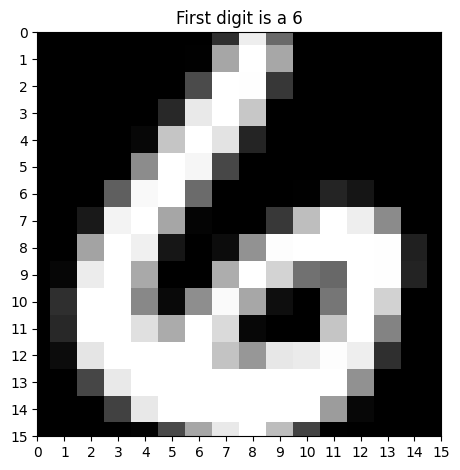

In [76]:
if execute:
    showKthImage(Xdigitstrain, ydigitstrain, 0)

<a name="learningproblem"></a>
## Task 2: Set up the Learning Problem. Compute the "Augmented" Feature Matrix: $\mathcal{X}$-space

<a name="features"></a>
### 2.1 Computing Features: Intensity and Symmetry
For the $n$-th example $\vec{x}_n$, we compute the following two features [See Lecture 10, LFD Example 3.1]:

1. \[See LFD Example 3.1\] $\text{intensity}=\frac{1}{256}\sum_{i=1}^{256}\vec{x}_n[i]$, where for any $i\in\{1,2,\dots,256\}$, $\vec{x}_n[i]$ is the value of the $i$-th pixel


2. \[See LFD Example 3.1\] $\text{symmetry}=\sum_{i=1}^{16}\sum_{j=1}^{16}(\boldsymbol{x}_n[i,j]-\boldsymbol{x}_n^{\text{flip}}[i,j])$, where
- $\boldsymbol{x}_n$ is the $16\times 16$ 2D matrix representation of the $n$-th 2D image
- for any matrix $\boldsymbol{x}$ representing a 2D image, $\boldsymbol{x}[i,j]$ is the value of the pixel in the $i$-th row and $j$-th column of the image
- $\boldsymbol{x}_n^{\text{flip}}$ is the matrix $\boldsymbol{x}_n$ flipped about the vertical axis, i.e. for any row $i\in\{1,2,\dots,16\}$, $\boldsymbol{x}_n^{\text{flip}}[i,j]=\boldsymbol{x}_n[i,16-j]$

In [77]:
'''
Computing Features
'''


def computeIntensity(X):
    '''
    Compute the average intensity feature
    Input:
        X: a 2 dimensional N x 256 numpy array
           each row contains the values of 256 pixels from a 16 x 16 grayscale image of a handwritten digit
           each pixel has an intensity value between -1 and 1
    Output:
        intensities: a 2 dimensional N x 1 numpy array
                     each row consists of a single value representing the
                     average pixel intesity of the corresponding image
                     See LFD Example 3.1
    '''
    print('computing intensity feature')
    N, d = X.shape
    print(f'Input shape {N}, {d}')
    intensities = np.matmul(X, np.ones((d, 1)))/d
    print(f'Output shape {intensities.shape}')
    return intensities


def computeSymmetry(X):
    '''
    Compute the symmetry feature
    Input:
        X: a 2 dimensional N x 256 numpy array
           each row contains the values of 256 pixels from a 16 x 16 grayscale image of a handwritten digit
           each pixel has an intensity value between -1 and 1
    Output:
        symmetries: a 2 dimensional N x 1 numpy array
                     each row consists of a single value representing the
                     "horizontal" symmetry of the 16 x 16 image about the vertical axis
                     See LFD Example 3.1
    '''
    print('computing symmetry feature')
    N, d = X.shape
    print(f'Input shape {N}, {d}')
    Ximgs = [X[n, :].reshape((16, 16)) for n in range(N)]
    Ximgs_flipped = [np.flip(Ximgs[n], axis=1) for n in range(N)]
    symmetries = [np.sum(np.abs((Ximgs[n] - Ximgs_flipped[n])
                                ).reshape(256, ))/d for n in range(N)]
    symmetries = -np.array(symmetries)
    symmetries = symmetries.reshape(N, 1)
    print(f'Output shape {symmetries.shape}')
    return symmetries

<a name="augmented"></a>
### 2.2 Compute the "Augmented Feature Matrix"

Given an input data set represented by an $N\times 256$ matrix with $N$ examples, each example represented by 256 pixels

Compute an $N\times 3$ augmented feature matrix $X_{\text{aug}}$

The first column of $X_{\text{aug}}$, $X_{\text{aug}}[:,1]$ is the $N\times 1$ column of ones, a dummy feature for mathematical convenience in order to accomodate the bias term in the linear model. See Lecture 2.

The second column of $X_{\text{aug}}$ is the $N\times 1$ column of average intensity values of the $N$ examples.

The second column of $X_{\text{aug}}$ is the $N\times 1$ column of symmetry values of the $N$ examples.

For any $n\in\{1,\dots,N\}$, $i\in\{1,2.3\}$, $X_{\text{aug}}[n,i]$ is the value at the $n-th$ row and $i$-th column of $X_{\text{aug}}$, and the value of the $i$-th feature for the $n$-th example.

In [78]:
'''
Computing the augmented feature matrix
'''


def computeAugmentedXWithFeatures(X):
    '''
    Compute the augmented feature matrix
    Input:
        X: a 2 dimensional N x 256 numpy array
           each row contains the values of 256 pixels from a 16 x 16 grayscale image of a handwritten digit
           each pixel has an intensity value between -1 and 1
    Output:
        Xaug: a 2 dimensional N x 3 numpy array
              the augmented feature matrix
              the i-th row corresponds to the i-th row of X (and image represented by it)
              the 0-th column is the column of 1s
              the 1-st column is the column of average intensities
              the 2-nd column is the column of horizontal symmetries
    '''
    N, d = X.shape
    intensity = computeIntensity(X)
    symmetry = computeSymmetry(X)
    dummy = np.ones((N, 1))
    Xaug = np.concatenate((dummy, intensity, symmetry), axis=1)
    # print(Xaug)
    print(f'Shape of augmented feature matrix: {Xaug.shape}')
    return Xaug

In [79]:
'''
Compute the augmented matrix with features
'''

if execute:
    print('Computing augmented training feature matrix')

    Xaugtrain = computeAugmentedXWithFeatures(Xdigitstrain)

    Naugtrain, d = Xaugtrain.shape

    print('Computing augmented test feature matrix')

    Xaugtest = computeAugmentedXWithFeatures(Xdigitstest)

    Naugtest, d = Xaugtest.shape

Computing augmented training feature matrix
computing intensity feature
Input shape 7291, 256
Output shape (7291, 1)
computing symmetry feature
Input shape 7291, 256
Output shape (7291, 1)
Shape of augmented feature matrix: (7291, 3)
Computing augmented test feature matrix
computing intensity feature
Input shape 2007, 256
Output shape (2007, 1)
computing symmetry feature
Input shape 2007, 256
Output shape (2007, 1)
Shape of augmented feature matrix: (2007, 3)


<a name="1v5"></a>
### Set up the 1s vs. 5s Classification Problem

In [80]:
'''
Create the dataset wih digits 1 and 5
'''


def indexDigits(y):
    '''
    A helper function to locate examples by label
    Input:
        y: N x 1 2 dimensional numpy array; labels for handwritten digits
    Output:
        digit_idxs: a dictionary; the keys are digits 0 -- 9
                    for a digit k, digit_idxs[k] is a list identifying the rows labeled with digit k
    '''
    N = y.shape[0]
    digit_idxs = {}
    for n in range(N):
        digit = ydigitstrain[n, 0]
        if not digit in digit_idxs:
            digit_idxs[digit] = []
        digit_idxs[digit].append(n)
    return digit_idxs

In [81]:
'''
Construct the training and test sets for the rest of the exercises on classifying 1s vs 5s
'''

if execute:
    digit_idxs_train = indexDigits(Xaugtrain)
    X1train = Xaugtrain[digit_idxs_train[1], :]
    print(X1train)
    N1train = X1train.shape[0]
    print(f'number of 1s: {N1train}')
    X5train = Xaugtrain[digit_idxs_train[5], :]
    print(X5train)
    N5train = X5train.shape[0]
    print(f'number of 5s: {N5train}')

    Xtrain = Xaugtrain[digit_idxs_train[1]+digit_idxs_train[5], :]
    ytrain = np.concatenate(
        (np.ones((N1train, 1)), -1*np.ones((N5train, 1))), axis=0)
    Ntrain, d = Xtrain.shape
    print(f'number of 1s and 5s: {Ntrain}')
    print(f'Xtrain shape: {Xtrain.shape}, ytrain shape: {ytrain.shape}')

[[ 1.         -0.75391406 -0.1174375 ]
 [ 1.         -0.77228125 -0.16229688]
 [ 1.         -0.76925781 -0.0595    ]
 ...
 [ 1.         -0.60979297 -0.21638281]
 [ 1.         -0.66230859 -0.09282031]
 [ 1.         -0.44755859 -0.13085156]]
number of 1s: 1005
[[ 1.         -0.11173828 -0.53372656]
 [ 1.         -0.56403516 -0.40299219]
 [ 1.         -0.392      -0.3865625 ]
 ...
 [ 1.         -0.26407812 -0.662     ]
 [ 1.         -0.28941406 -0.58520312]
 [ 1.         -0.53423828 -0.51378906]]
number of 5s: 556
number of 1s and 5s: 1561
Xtrain shape: (1561, 3), ytrain shape: (1561, 1)


In [82]:
if execute:
    digit_idxs_test = indexDigits(Xaugtest)
    Xtest = Xaugtest[digit_idxs_test[1]+digit_idxs_test[5], :]
    ytest = np.concatenate((np.ones(
        (len(digit_idxs_test[1]), 1)), -1*np.ones((len(digit_idxs_test[5]), 1))), axis=0)
    Ntest, d = Xtest.shape
    print(f'number of 1s and 5s: {Ntest}')
    print(f'Xtest shape: {Xtest.shape}, ytest shape: {ytest.shape}')

number of 1s and 5s: 428
Xtest shape: (428, 3), ytest shape: (428, 1)


<a name="scatter"></a>
### 2.3 [Visualizing Data: Plot Data Points in 2 dimensions](#scatter)

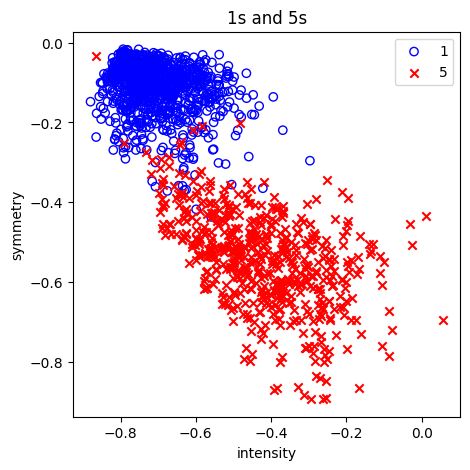

In [83]:
'''
Plot the training data
'''

if execute:
    fig, axs = plt.subplots(figsize=(5, 5))
    axs.scatter(X1train[:, 1], X1train[:, 2], marker='o',
                color='blue', facecolors='none', label='1')
    axs.scatter(X5train[:, 1], X5train[:, 2], marker='x', color='red', label='5')
    axs.set_xlabel('intensity')
    axs.set_ylabel('symmetry')
    axs.set_title('1s and 5s')
    axs.legend()

<a name="linear"></a>
## Task 3: The Linear Model (in $\mathcal{X}$-space)

Unless otherwise specified, $X$ will represent the $N\times d$ 'augmented' matrix of data points with $d$ features where the first feature is the dummy feature of all ones.


<a name="plotlin"></a>
### 3.1 Plotting a Linear Separator

In 2D Space, given

$w$: $3\times 1$ vector of weights

$X$: $N\times 3$ matrix of data points with two features

$y$: $N\times 1$ vector of labels

Generate a plot that:

1. Shows a scatter plot of $N$ data points in $X$. Data points with label +1 indicated by a <font style="color:blue;">blue circle  'o'</font> and data points with label -1 indicated by a <font style="color:red;">red cross 'x'</font>

2. Displays A line plot of the linear separator defined by the weights $w$. Having generated values of $x[1]$, compute $x[2]=-\frac{w[0] + w[1]x[1]}{w[2]}$

In [84]:
'''
Helper function to plot a linear separator
'''


def plotLinearSeparator(w, X, y, title='', Xs=None, Xlabels=None, markers=None):
    '''
    Plot data points a linear separator
    Input:
        w: a 2D (d+1) x 1 numpy array
        X: a 2D N x (d+1) numpy array
        y: a 2D N x 1 numpy array
        title: a string
    Output:
        error: misclassification error of hypothesis w on data points in X with true labels y
    '''
    '''
    Plot data points in X, y
    '''
    plus1s = np.where(y == 1)[0]
    minus1s = np.where(y == -1)[0]
    Xplus1s = X[plus1s, :]
    Xminus1s = X[minus1s, :]
    fig, axs = plt.subplots(figsize=(5, 5))
    axs.scatter(Xplus1s[:, 1], Xplus1s[:, 2], marker='o',
                color='blue', facecolors='none', label='1')
    axs.scatter(Xminus1s[:, 1], Xminus1s[:, 2],
                marker='x', color='red', label='5')
    axs.set_xlabel('intensity')
    axs.set_ylabel('symmetry')
    axs.set_xlim(-1, 0.2)
    axs.set_ylim(-1, 0.1)
    '''
    Plot separator
    '''
    pltxs = np.linspace(-1, 0.21)
    pltys = - (w[0] + w[1] * pltxs) / w[2]
    axs.plot(pltxs, pltys, color='green', label='separator')
    axs.set_title(title)
    axs.legend()
    plt.show()

<a name="error"></a>
### 3.2 The Point-wise Error Function of a Linear Hypothesis for Classification

Given:

- $w$: $d\times 1$ vector of weights

- $X$: $N\times d$ 'augmented' matrix of $N$ data points with $d$ features.

- $y$: $N\times 1$ vector of labels

Compute the average misclassification error of the linear hypothesis defined by weights $w$ on the $N$ data points in $X$ w.r.t. the $N$ labels in $y$.

1. Use $w$ to make predictions $\hat{y}$ on $X$. $\hat{y}$ is an $N\times 1$ vector of predictions. $\hat{y}\gets\text{sign}(Xw)$, i.e. the prediction on the $n$-th data point is $\hat{y}[n,1]\gets\text{sign}(X[n,:]w[:,1])$. Tip: See <a href="https://numpy.org/doc/stable/reference/generated/numpy.matmul.html#numpy-matmul">numpy.matmul()</a> and <a href="https://numpy.org/doc/stable/reference/generated/numpy.sign.html#numpy-sign">numpy.sign()</a>.

2. Compute the average misclassification error.
$E\gets\frac{1}{N}\sum_{n=1}^N \frac{1-y[n]\hat{y}[n]}{2}$. Tip: This operation can be vectorized $E\gets\frac{1}{2N}(\vec{1}-y*\hat{y})$, where '$*$' represents the element-wise multiplication of two vectors and $\vec{1}$ is the $N\times 1$ vector of ones. See <a href="https://numpy.org/doc/stable/reference/generated/numpy.multiply.html#numpy-multiply">numpy.multiply()</a> to perform an element-wise multiplication of two arrays, and <a href="https://numpy.org/doc/stable/reference/generated/numpy.sum.html">numpy.sum()</a> to sum up the elements of an array.


In [85]:
def predictClassLinear(w, X):
    '''
    Input:
        w: a 2D (d+1) x 1 numpy array of weights for a linear hypothesis
        X: a 2D N x (d+1) numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set
           X[n, 0] = 1
           X[n, 1], ..., X[n, d] have values of features
    Output:
        yhat: an N x 1 2 dimensional numpy array orf predictions
    '''
    yhat = np.sign(np.matmul(X, w))
    return yhat

In [105]:
'''
Functions to compute the misclassification error
'''


def error(w, x, y, R=None):
    '''
    point-wise error measure for classification
    Input:
        w: a d x 1 2 dimensional numpy array
        x: a d x 1 2 dimensional numpy array
        y: a scalar value
        R: Risk weights; a dictionary
           whose keys are tuples (y, yhat) with
           value equal to the cost of predicting yhat when the label is y
    Output:
        error: misclassification error of hypothesis w on data point x with true label y
    '''
    '''
    TODO: Compute the error of the linear model with weights w on data point x with label y
    yhat = ?
    error = ?
    return error
    '''
    yhat = np.dot(w.T, x)
    error = R.get((y, yhat), 1)
    return error


def E(w, X, y, R=None):
    '''
    point-wise error measure for classification
    Input:
        w: a d x 1 2 dimensional numpy array
        X: an N x d 2 dimensional numpy array
        y: an N x 1 2 dimensional numpy array
        R: Risk weights; a dictionary
           whose keys are tuples (y, yhat) with
           value equal to the cost of predicting yhat when the label is y
    Output:
        error: misclassification error of hypothesis w on data points in X with true labels y
    '''
    N = X.shape[0]
    '''
    TODO: Compute the (average) misclassification error of the linear model with weights w
    on the data points in the data set X whose labels are in y
    yhat = ?
    error = ?
    return error
    '''
    yhat = np.sign(np.matmul(X, w))
    error = np.sum(np.abs(y - yhat))/2/N
    return error

<a name="pocket"></a>
### 3.3 The Pocket Algorithm (and the Perceptron Learning Algorithm)

Given:

- $X$: $N\times d$ 'augmented' matrix of $N$ data points with $d$ features.

- $y$: $N\times 1$ vector of labels

- $w$: optionally, a $d\times 1$ vector of weights to initialize the algorithm

In each iteration:

1. The current weights are represented by $\vec{w}(t)$.

2. Make predictions $\hat{y}$.

3. Find a misclassified data point $\vec{x}_*$, where $\hat{y}[*]\neq y[*]$.

2. Update the weights. Set $\vec{w}(t+1)\gets \vec{w}(t) + y[*]\vec{x}_*$. Notice that $\vec{w}(t)$, $\vec{w}(t+1)$, and $\vec{x}_*$ are $d\times 1$ vectors.

In [108]:
'''
The Pocket algorithm (variant of the Perceptron Learning Algorithm)
'''


def pocket(X, y, max_iters=1000, w_init=None):
    '''
    Implements the Pocket algorithm
    Input:
        X: a 2D N x (d+1) numpy array
           The i-th row X[i, :] contains features for the i-th example in the training set
           X[i, 0] = 1
           X[i, 1], ... X[i, d] have values of features
        y: a 2D N x 1 numpy array
           y[i, 0] is the label associated with the i-th example
        max_iters: an integer; maximum number of iterations of PLA
        w_init: a 2D (d+1) x 1 numpy array
                intended to set initial weights for PLA
    Output:
        w_best: a 2D (d+1) x 1 numpy array, weights with lowest error on the input training set X, y
    '''
    Eins = []
    ws = []

    Ein_best = np.infty
    w_best = 0

    w = np.zeros((d, 1))
    w = w + 0.0000001
    if not isinstance(w_init, type(None)):
        w = w_init

    for i in range(max_iters):
        Ein = E(w, X, y)
        Eins.append(Ein)
        ws.append(w)
        if Ein < Ein_best:
            Ein_best = Ein
            w_best = w
        yhat = np.sign(np.matmul(X, w))
        nstar = np.where(yhat != y)[0][0]
        xstar = X[nstar, :].reshape((d, 1))
        ystar = y[nstar, 0]
        w = w + ystar * xstar

    plt.scatter(range(max_iters), Eins)
    plt.xlabel('iteration')
    plt.ylabel('in sample error')
    plt.title('PLA')
    plt.tight_layout()
    plt.show()

    print(f'Ein_best {Ein_best}, \nw_best \n{w_best}')

    return w_best

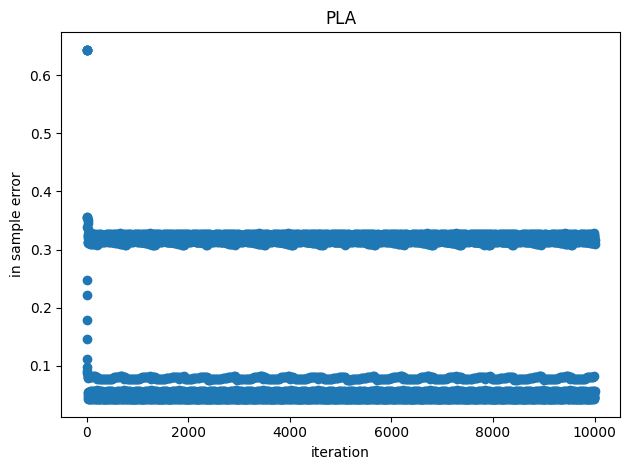

Ein_best 0.04228058936579116, 
w_best 
[[ 1.00000000e-07]
 [-2.11429287e+00]
 [ 2.92742979e+00]]


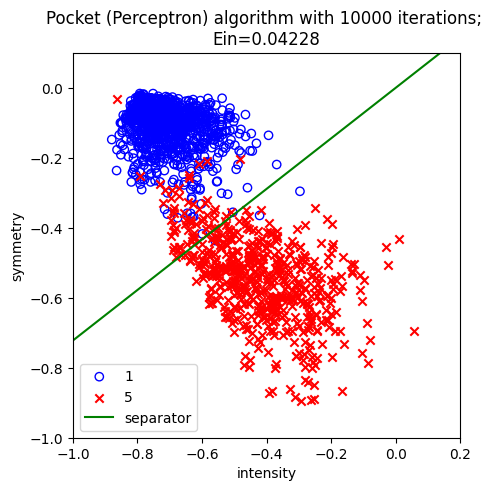

In [109]:
'''
Run the Pocket algorithm
'''

if execute:
    max_iters = 10000
    w = pocket(Xtrain, ytrain, max_iters=max_iters)
    Ein = np.round(E(w, Xtrain, ytrain), 5)
    plotLinearSeparator(
        w, Xtrain, ytrain, title=f'Pocket (Perceptron) algorithm with {max_iters} iterations; \nEin={Ein}')

<a name="linreg"></a>
### 3.4 Linear Regression: The One Step $E_\text{in}$ Minimizing Algorithm

Minimize the sum of square errors. See Lecture 11.

Given:

- $X$: $N\times d$ 'augmented' matrix of $N$ data points with $d$ features.

- $y$: $N\times 1$ vector of labels

Compute weights $w$ to represent a linear hypothesis which has minimum sum of square errors, i.e., the predictions made by the linear hypothesis are given by the $N\times 1$ vector $\hat{y}=Xw$, and the error of the hypothesis is $E_{X,y}(w)=\frac{1}{N}(w^TX^TXw-2w^TX^Ty+y^Ty)$.

Output $w_\text{lin}\in\arg\min_{w\in\mathbb{R}^d}E_{X,y}(w)$.

$w_{\text{lin}}\gets X^\dagger y$, where $X^\dagger=(X^TX)^{-1}X^T$ if $X^TX$ is invertible, and $X^\dagger$ is the pseudo-inverse of $X$ otherwise. Tip: Compute $X^\dagger$ to be the pseudo-invese of $X$. See <a href="https://numpy.org/doc/stable/reference/generated/numpy.linalg.pinv.html#numpy-linalg-pinv">numpy.linalg.pinv()</a>.

In [110]:
'''
The one-step optimal algorithm for Linear Regression
'''


def linearRegression(X, y):
    '''
    Implements the one-step algorithm for Linear Regression
    Input:
        X: A 2D N x (d+1) numpy array
           The i-th row X[i, :] contains features for the i-th example in the training set
           X[i, 0] = 1
           X[i, 1], ... X[i, d] have values of features
        y: A 2D N x (d+1) numpy array
           y[i, 0] is the label associated with the i-th example
    Output:
        w: weights with lowest error on the input training set X, y
    '''
    '''
    TODO: Compute the optimal weights which minimizes the sum of squared errors
    w_lin = ?
    '''
    X_transpose = X.T
    w_lin = np.matmul(np.matmul(np.linalg.inv(np.matmul(X_transpose, X)), X_transpose), y)
    #print(w_lin)
    return w_lin

[[ 1.0012006 ]
 [-0.42708976]
 [ 3.6520302 ]]


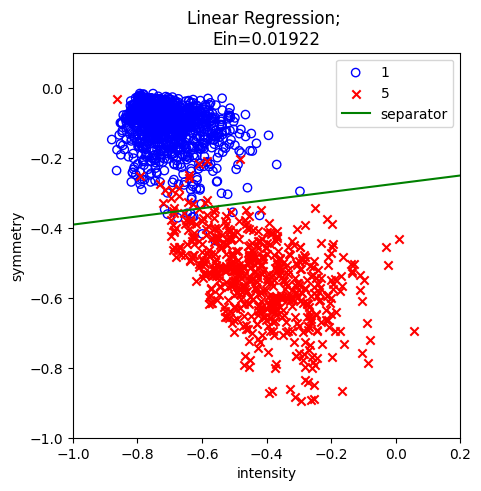

In [111]:
'''
Run Linear Regression followed by the Pocket algorithm to classify 1s vs 5s
'''

if execute:
    w_lin = linearRegression(Xtrain, ytrain)
    Ein = np.round(E(w_lin, Xtrain, ytrain), 5)
    plotLinearSeparator(w_lin, Xtrain, ytrain,
                        title=f'Linear Regression; \nEin={Ein}')

<a name="linreg4class"></a>
#### 3.4.1 Linear Regression for Classification

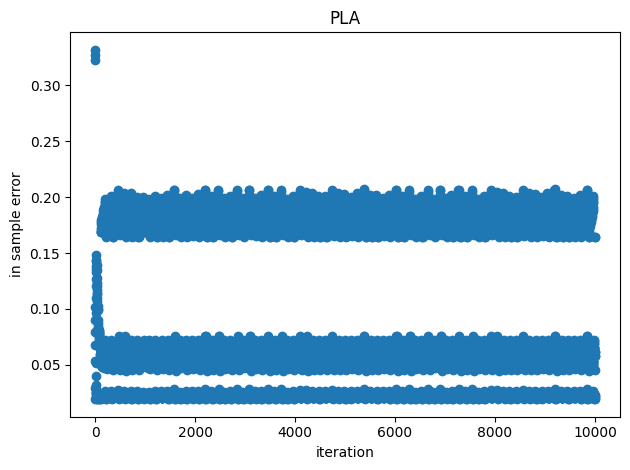

Ein_best 0.019218449711723255, 
w_best 
[[ 1.0012006 ]
 [-0.42708976]
 [ 3.6520302 ]]


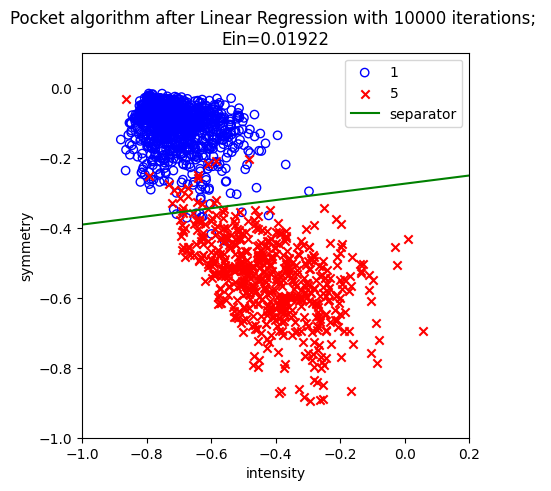

In [112]:
'''
Linear Regression for Classification:
Use Linear Regression to obtain an initial setting of the weights for the Pocket Algorithm
'''

if execute:
    max_iters = 10000
    w = pocket(Xtrain, ytrain, w_init=w_lin, max_iters=max_iters)
    Ein = np.round(E(w, Xtrain, ytrain), 5)
    plotLinearSeparator(w, Xtrain, ytrain,
                        title=f'Pocket algorithm after Linear Regression with {max_iters} iterations; \nEin={Ein}')

<a name="logreg"></a>
### 3.5 Logistic Regression

<a name="gradmin"></a>
#### 3.5.1 An Example of Gradient Descent: Minimizing a function's value

$f(x,y)$ is the function in the homework question

The goal is to find the value of $x$ and $y$ at which the value of the function is minimized.

Unfortunately, $f(x,y)$ is not convex. So gradient descent can only find a local minimum, which will depend on the starting values of $x$ and $y$ and the step size $\eta$.

In order to conduct gradient descent, you will implement a function that computes the gradient at any given values of $x$ and $y$, i.e., you will have to derive and implement the expressions for $\frac{\partial f(x,y)}{\partial x}$ and $\frac{\partial f(x,y)}{\partial y}$. Finally, you will implement the update step and the gradient descent algorithm to find the (local) minimum for $f(x,y)$.

##### Tip: You may use a graphing calculator or an online tool like Wolfram Alpha to plot the function to build an intuition for why minimizing this function may be non-trivial.

In [113]:
'''
Gradient descent to minimize an arbitrary function
'''


def functionf(x, y):
    '''
    Computes the value of an arbitrary function in two variables at the input location
    '''
    '''
    TODO: return the value of the function at (x, y)
    return ?
    '''
    return x**3 + y**3

def gradientf(x, y):
    '''
    Computes the gradient of an arbitrary function in two variables at the input location
    '''
    '''
    TODO: compute the gradient
    df_by_dx = ?
    df_by_dy = ?
    '''
    df_by_dx = 3 * (x**2)
    df_by_dy = 3 * (y**2)
    return df_by_dx, df_by_dy


def gradientDescent4f(x, y, eta=0.001, max_iters=100):
    '''
    Performs gradient descent to find the location at which the value of an arbitrary function is minimized
    '''
    fvals = []
    for i in range(max_iters):
        # print(f'iteration {i}, x={x}, y={y}')
        fval = functionf(x, y)
        fvals.append(fval)
        grad = gradientf(x, y)
        '''
        TODO: Update x, y
        x = ?
        y = ?
        '''
        x = x - eta * grad[0]
        y = y - eta * grad[1]
    plt.plot(range(max_iters), fvals)
    plt.xlabel('iteration')
    plt.ylabel('value of f')
    plt.show()
    return x, y

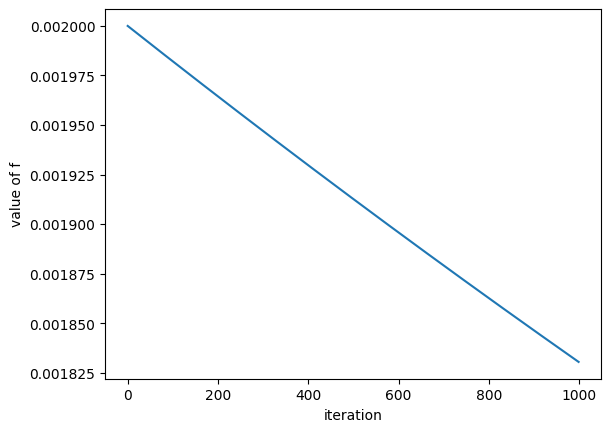

In [114]:
if execute:
    max_iters = 1000
    eta = 0.0001
    gradientDescent4f(0.1, 0.1, eta=eta, max_iters=max_iters)

<a name="logreggrad"></a>
#### 3.5.2 Logistic Regression: Cross Entropy Error and Gradient Descent

Find a linear hypothesis which minimizes the cross entropy error. See Lectures 12 and 13.

Given:

- $X$: $N\times d$ 'augmented' matrix of $N$ data points with $d$ features.

- $y$: $N\times 1$ vector of labels

- $\eta$: a positive scalar value, the 'learning rate' or 'step size' for gradient descent

Compute weights $w$ to represent a linear hypothesis which (approximately) minimizes cross entropy error. The linear signal on a data point $x$ is $s=w^Tx$, and the probability predicted is the output of the sigmoid function $\theta$ applied to the linear signal, i.e. $\theta(s)=\frac{1}{1+e^{-s}}$.

The cross entropy error of a hypothesis with weights $w$ on datapoints in $X$ with labels in $y$ is:

$E_{X,y}(w)=\frac{1}{N}\sum_{n=1}^{N}\ln (1 +e^{-y_n w^T x_n})$.

The weights of the output hypothesis are computed using gradient descent iteratively. In each iteration the weights are updated as follows:

1. Compute the gradient at current weights $w$, a $d\times 1$ vector: $\nabla E_{X,y}(w)=\frac{1}{N}\sum_{n=1}^N -y_n x_n \theta(-y_n w^T x_n)$.

2. Update weights by taking a small step towards the negative of the gradient to lower that value of $E_{X,y}$: $w\gets-\eta\nabla E_{X,y}(w)$.

In [94]:
'''
The Logistic Regression algorithm with the cross entropy error measure
'''

'\nThe Logistic Regression algorithm with the cross entropy error measure\n'

In [115]:
def sigmoid(s):
    '''
    Implements the sigmoid function
    '''
    '''
    TODO: Implement the sigmoid function
    return ?
    '''
    return 1 / (1 + np.exp(-s))

In [96]:
def gradientCrossEntropyError(w, X, y):
    '''
    Computes the gradient of the cross entropy error function on the dataset X, y at input weights w
    See LFD Exercise 3.7
    Input:
        w: a 2D (d+1) x 1 numpy array
        X: a 2D N x (d+1) numpy array
        y: a 2D N x 1 numpy array
    Output:
        gradient: a 2D (d+1) x 1 numpy array,
                  gradient of the cross entropy error function on the dataset X, y at input weights w
    '''
    N, d = X.shape
    grad = np.zeros((d, 1))
    '''
    TODO: Compute the gradient at w
    for n in range(N):
        ?
    '''
    for i in range(N):
      yhat = sigmoid(np.dot(w.T, X[i, :]))
      grad += (yhat - y[i]) * X[i, :].reshape(-1, 1)
    grad = grad/N
    return grad

In [97]:
def logisticRegression(X, y, eta=0.001, w_init=None, max_iters=1000):
    '''
    Implements the gradient descent algorithm for Logistic Regression
    See LFD Example 3.3
    Input:
        X: A 2D N x (d+1) numpy array
           The i-th row X[i, :] contains features for the i-th example in the training set
           X[i, 0] = 1
           X[i, 1], ... X[i, d] have values of features
        y: A 2D N x 1 numpy array
           y[i, 0] is the label associated with the i-th example
        eta: positive real number, learning rate
        w_init: A 2D (d+1) x 1 numpy array, initial weights to start gradient descent
        max_iters: positive integer, maxmimum number of iterations of gradient descent
    Output:
        w: A 2D (d+1) x 1 numpy array, weights with (approximately) lowest error on the input training set X, y
    '''
    N, d = X.shape
    w = np.zeros((d, 1))
    if not isinstance(w_init, type(None)):
        w = w_init
    Eins = []
    for i in range(max_iters):
        Ein = E(w, X, y)
        Eins.append(Ein)
        grad = gradientCrossEntropyError(w, X, y)
        '''
        TODO: Complete the implementation of the gradient descent algorithm
        w += ?
        '''
        w += -(eta * grad)
    plt.plot(range(max_iters), Eins)
    return w

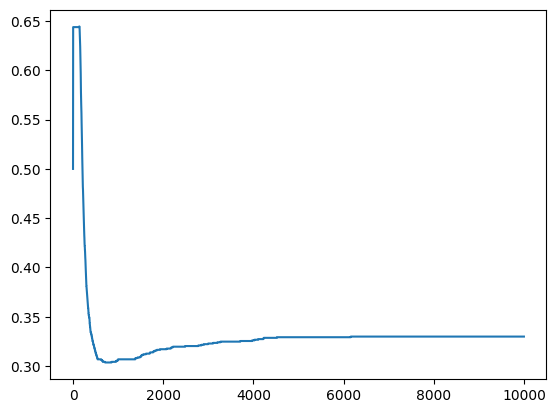

In [120]:
'''
Run the logistic regression algorithm to classify 1s vs 5s
'''

if execute:
    max_iters = 10000 #100000 would cause an overload
    eta = 0.1
    w_log = logisticRegression(Xtrain, ytrain, eta=eta, max_iters=max_iters)

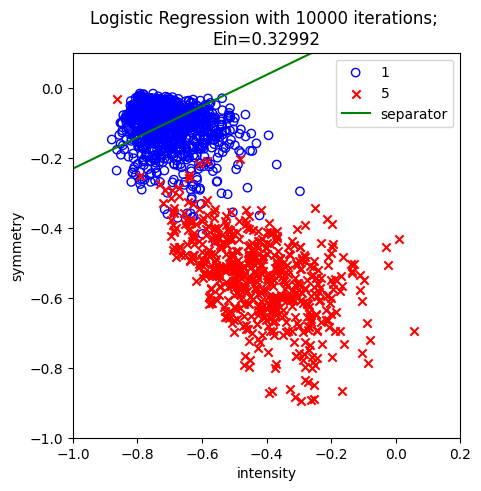

In [121]:
if execute:
    Ein = np.round(E(w_log, Xtrain, ytrain), 5)
    plotLinearSeparator(w_log, Xtrain, ytrain,
                        title=f'Logistic Regression with {max_iters} iterations; \nEin={Ein}')

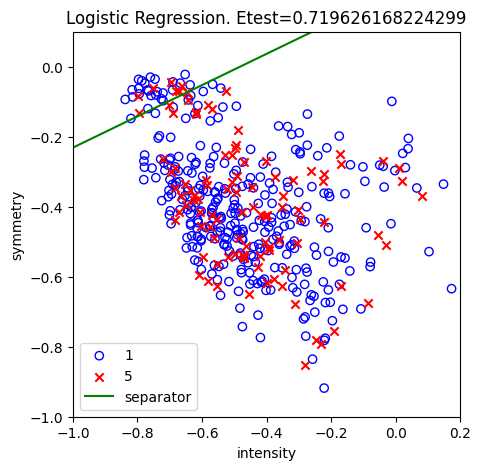

In [122]:
if execute:
    Etest = E(w_log, Xtest, ytest)
    plotLinearSeparator(w_log, Xtest, ytest,
                        title=f'Logistic Regression. Etest={Etest}')

<a name="polytrans"></a>
## Task 4: The Polynomial Transform: $\mathcal{Z}$-space

<a name="computepoly"></a>
### 4.1 Compute the Polynomial Features

Input:

- $X$: $N\times d$ 'augmented' matrix of $N$ data points with $d$ features.

- $Q$: an integer for the desired polynomial transform.

Output:

- $Z$: $N\times \tilde{d}$ 'augmented' matrix of $N$ data points with $\tilde{d}$ features corresponding to the $Q$-th degree polynomial transform of the data in $X$.

$\vec{z}_n=Z[n,:]^T$ is the polynomial transform of $\vec{x}_n=X[n,:]^T$, the $n$-th example.

In [123]:
def polynomialTransform(X, Q):
    '''
    Compute the polynomial transform features
    See LFD Example 3.3
    Input:
        X: a 2D N x (d+1) numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set
           X[n, 0] = 1
           X[n, 1], ..., X[n, d] have values of features
        Q: positive integer, the desired degree of polynomial
    Output:
        Z: A 2D N x (dtilde+1) numpy array
           The n-th row Z[n, :] contains features corresponding to the Q-th order polynomial transform of X[n, :]
           Z[n, 0] = 1
           Z[n, 1], ..., Z[dtilde] contain the transformed features
    Warning and NOTE: This is a hack! Can we do better?
    '''
    '''
    Init
    '''
    N, d = X.shape
    if np.all(X[:, 0] == np.ones((N, 1))):
        X = X[:, 1:]
    N, d = X.shape
    # NOTE: Compute the features of the Q-th order polynomial transform.
    # It may be easier to implement it only for the value of Q specified in the homework
    # instead of implementing it for all possible values of Q.
    degrees = range(Q+1)
    perms = permutations(range(d))
    perms = list(perms)
    combs = combinations_with_replacement(degrees, d)
    combs = list(combs)
    '''
    List feature names
    '''
    terms = []
    ftnames = []
    for c in combs:
        if np.sum(c) == 0:
            continue
        if np.sum(c) > Q:
            continue
        for p in perms:
            ftname = '*'.join(sorted([f'x[{p[i]}]^{c[i]}' for i in range(d)]))
            if ftname in ftnames:
                continue
            terms.append((c, p))
            ftnames.append(ftname)
    '''
    Compute features
    '''
    Z = []
    for n in range(N):
        x = X[n, :]
        z = []
        for t in terms:
            (c, p) = t
            v = np.prod([x[p[i]]**c[i] for i in range(d)])
            z.append(v)
        z = [1] + z
        Z.append(z)
    Z = np.array(Z)
    return Z

In [ ]:
if execute:
    Xdebug = [[1, 2, 3]]
    Xdebug = np.array(Xdebug)

    Z = polynomialTransform(Xdebug, 3)

    print(f'Z shape {Z.shape}')
    print(Z)

In [ ]:
if execute:
    Q = 3
    Ztrain = polynomialTransform(Xtrain, Q)
    Ztest = polynomialTransform(Xtest, Q)

<a name="plotpoly"></a>
### 4.2 Plotting a Non-Linear Separator

Given a linear model in $\mathcal{Z}$-space, the polynomial transform of data points in 2D $\mathcal{X}$-space, plot the 'effective' (non-linear) separator in 2D $\mathcal{X}$-space. Notice that any separator partitions $\mathcal{X}$-space into two parts (points that are predicted to be one of either +1 or -1). Illustrating the partitions by 'coloring' the space effective shows the separator in action on $\mathcal{X}$-space. To do so:
- Generate a 'dense' grid of data points in $\mathcal{X}$-space.
- Transform these data points to obtain the corresponding data points in $\mathcal{Z}$-space.
- Make a prediction using the linear hypothesis in $\mathcal{Z}$-space.
- Color the corresponding original data points in $\mathcal{X}$-space using these predictions.

In [124]:
def plotNonLinearSeparator(w, X, y, Q=2, title=''):
    '''
    Plot the "effective" decision boundary and half spaces
    determined by a non-linear separator in 2D space
    which is picked from a linear model in higher dimensional space
    using the polynomial transform
    Input:
        w: a (d+1) x 1 2 dimensional numpy array of weights for a linear hypothesis
        X: a 2D N x (d+1) numpy array
           The n-th row X[n, :] contains features for the n-th example in the training set
           X[n, 0] = 1
           X[n, 1], ..., X[n, d] have values of features
        y: a 2D N x (d+1) numpy array
           y[i, 0] is the label associated with the i-th example
        Q: The desired degree of polynomial
        title: a string
    Output:
        No output
    '''
    fig, axs = plt.subplots(figsize=(5, 5))
    '''
    Plot separator
    '''
    pltx1s = np.linspace(-1, 0.21, 100)
    pltx2s = np.linspace(-1, 0.1, 100)
    pltX = np.array([[1, x, y] for x in pltx1s for y in pltx2s])
    # a function that performs the polynomial transform
    pltZ = polynomialTransform(pltX, Q=Q)
    pltyhat = predictClassLinear(w, pltZ)
    pltx1s = pltX[:, 1].reshape((pltX.shape[0], 1))
    pltx2s = pltX[:, 2].reshape((pltX.shape[0], 1))
    cmap = ListedColormap(['lightcoral', 'lightskyblue'])
    axs.scatter(pltx1s, pltx2s, c=pltyhat, cmap=cmap)
    '''
    Plot data points
    '''
    plus1s = np.where(y == 1)[0]
    minus1s = np.where(y == -1)[0]
    Xplus1s = X[plus1s, :]
    Xminus1s = X[minus1s, :]
    axs.scatter(Xplus1s[:, 1], Xplus1s[:, 2], marker='o',
                color='blue', facecolors='none', label='1')
    axs.scatter(Xminus1s[:, 1], Xminus1s[:, 2],
                marker='x', color='red', label='5')
    '''
    Finishing touches
    '''
    axs.set_xlabel('intensity')
    axs.set_ylabel('symmetry')
    axs.set_xlim(-1, 0.2)
    axs.set_ylim(-1, 0.1)
    axs.set_title(title)
    axs.legend()
    plt.show()

<a name="learnZ"></a>
### 4.3 Learning a Linear Separator in $\mathcal{Z}$-space, a Non-Linear Separator in $\mathcal{X}$-space

In [125]:
'''
This is just a quick and dirty example
'''

if execute:
    w_lin = linearRegression(Ztrain, ytrain)
    Ein = np.round(E(w_lin, Ztrain, ytrain), 5)

[[  0.65603268]
 [  2.15640533]
 [ -3.42823675]
 [-10.32598605]
 [ -6.68092501]
 [-14.41072705]
 [ -3.65584901]
 [  1.56257182]
 [  9.05288142]
 [ -4.47318465]]


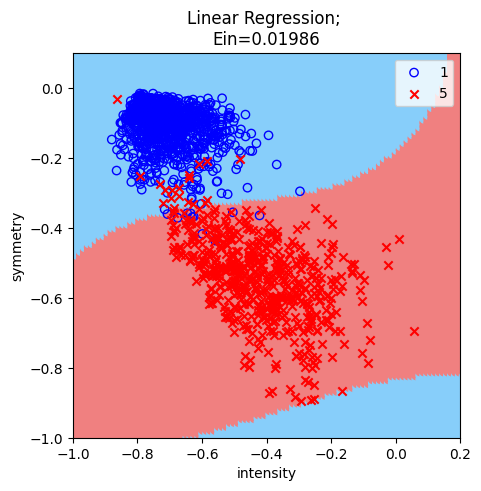

In [126]:
if execute:
    plotNonLinearSeparator(w_lin, Xtrain, ytrain, Q=Q,
                           title=f'Linear Regression; \nEin={Ein}')